In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

# Data Visualization

import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE
import joblib

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

#extract lyrics
import lyricsgenius

C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#eda
p2_survey = pd.read_csv('../python/mbtidata.csv')
#p2 = pd.read_csv('../python/p2_lyric1000.csv')
#remove unwanted words in order to get valid model accuracy estimation for unseen data. 
remove_words = '|'.join(['Chorus', 'Lyrics', 'Intro', 'Verse','Outro','Post-Chorus:','Pre-Chorus', 'Embed','Bridge'])
p2_survey["lyrics"] = p2_survey["lyrics"].str.replace(remove_words, '')
p2_survey.head()

,Unnamed: 0,Unnamed: 0.1,TopSongs,lyrics,MBTI
0,0,0,Sza - love galore,Love Galore [Part I]. . [: Travis Scott]. I ne...,ENFJ
1,1,1,Lucky daye - over,"Over [ 1]. Every time we link up, it's only us...",ENFJ
2,2,2,Summer Walker & Usher - Come Thru,Come Thru []. We got London on da Track. . [ 1...,ENFJ
3,3,3,Jhene aiko - while we're young,"While We’re Young [ 1]. Baby, while we're youn...",ENFJ
4,4,4,"Slchld - she likes spring, i prefer winter","​she likes spring, i prefer winter []. Stay by...",ENFJ


In [3]:
#p2_survey ['all_lyrics'] = new_df['lyrics']
#p2_survey['MBTI'] = p2['MBTI_Type'].str.split('-').str[0]
p2_survey.head()

,Unnamed: 0,Unnamed: 0.1,TopSongs,lyrics,MBTI
0,0,0,Sza - love galore,Love Galore [Part I]. . [: Travis Scott]. I ne...,ENFJ
1,1,1,Lucky daye - over,"Over [ 1]. Every time we link up, it's only us...",ENFJ
2,2,2,Summer Walker & Usher - Come Thru,Come Thru []. We got London on da Track. . [ 1...,ENFJ
3,3,3,Jhene aiko - while we're young,"While We’re Young [ 1]. Baby, while we're youn...",ENFJ
4,4,4,"Slchld - she likes spring, i prefer winter","​she likes spring, i prefer winter []. Stay by...",ENFJ


In [4]:
p2_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1000 non-null   int64 
 1   Unnamed: 0.1  1000 non-null   int64 
 2   TopSongs      1000 non-null   object
 3   lyrics        1000 non-null   object
 4   MBTI          1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [5]:
#size of dataset
nRow, nCol = p2_survey.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 5 columns


In [6]:
p2_survey.dtypes

Unnamed: 0       int64
Unnamed: 0.1     int64
TopSongs        object
lyrics          object
MBTI            object
dtype: object

In [3]:
p2_survey = p2_survey[['MBTI', 'TopSongs','lyrics']]
p2_survey.head()

,MBTI,TopSongs,lyrics
0,ENFJ,Sza - love galore,Love Galore [Part I]. . [: Travis Scott]. I ne...
1,ENFJ,Lucky daye - over,"Over [ 1]. Every time we link up, it's only us..."
2,ENFJ,Summer Walker & Usher - Come Thru,Come Thru []. We got London on da Track. . [ 1...
3,ENFJ,Jhene aiko - while we're young,"While We’re Young [ 1]. Baby, while we're youn..."
4,ENFJ,"Slchld - she likes spring, i prefer winter","​she likes spring, i prefer winter []. Stay by..."


In [4]:

#all values are textual, hence they have to be converted to numerical form to train the ML model
p2_survey.describe(include=['object'])

,MBTI,TopSongs,lyrics
count,1000,1000,1000
unique,16,933,829
top,INFJ,every summertime,Angel Baby [ 1]. I need a lover to keep me san...
freq,130,4,11


In [5]:
#finding the unique values from the 'MBTI_Type' of personality column
types = np.unique(np.array(p2_survey['MBTI']))
types


array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [6]:
total = p2_survey.groupby(['MBTI']).count()*50
total

,TopSongs,lyrics
MBTI,,
ENFJ,5250,5250
ENFP,3000,3000
ENTJ,2500,2500
ENTP,2250,2250
ESFJ,3750,3750
ESFP,2500,2500
ESTJ,2000,2000
ESTP,1750,1750
INFJ,6500,6500


Text(0.5, 1.0, 'Total lyrics count for each personality type')

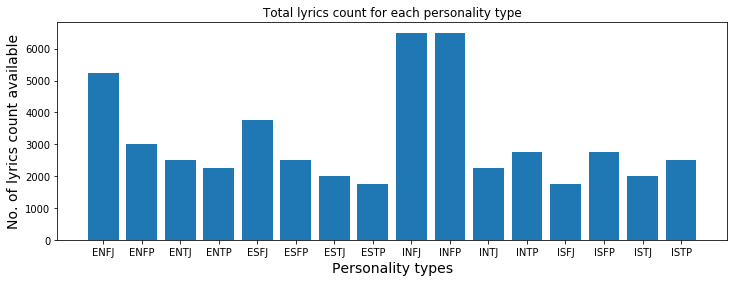

In [7]:
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['lyrics'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of lyrics count available', size = 14)
plt.title('Total lyrics count for each personality type')

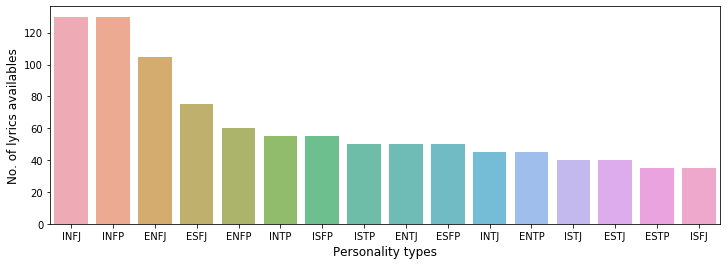

In [10]:
import seaborn as sns 
#Plotting this in descending order for better understanding of this visualization
cnt_srs = p2_survey['MBTI'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of lyrics availables', fontsize=12)
plt.show()

# the most common users personality is 
INFP (Introvert Intuition Feeling Perceiving).

However, we reach this conclusion based on user comments: we can consider for now that users who's willing to fill up the survey are more intoverted, perceptive, and emotional.

In [11]:
#p2.tail()
p2_survey['lyrics'].isnull().values.any()

False

In [13]:
#p2_survey[p2_survey['lyrics'].isna()] # print row with missing values

In [14]:
#p2['lyric']=p2['lyric'].fillna("") # change nan to " "

In [12]:
#Finding the most common words in all posts.
words = list(p2_survey["lyrics"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)

[('the', 25171),
 ('I', 17004),
 ('and', 13824),
 ('to', 13594),
 ('a', 11846),
 ('you', 11100),
 ('of', 9437),
 ('in', 8318),
 ('-', 7830),
 ('.', 7794),
 ('my', 6052),
 ('that', 5362),
 ('me', 4732),
 ('it', 4586),
 ('on', 4524),
 ('for', 4378),
 ('is', 4241),
 ('with', 4160),
 ("I'm", 4003),
 ('be', 3763),
 ('And', 3725),
 ('your', 3624),
 ('[].', 3343),
 ('all', 3297),
 ('The', 2936),
 ('we', 2813),
 ('like', 2712),
 ('his', 2640),
 ('he', 2588),
 ('You', 2536),
 ('was', 2407),
 ("don't", 2392),
 ('know', 2310),
 ('[', 2260),
 ('at', 2172),
 ('when', 2061),
 ('this', 2055),
 ('have', 2036),
 ('but', 2023),
 ('are', 1983)]

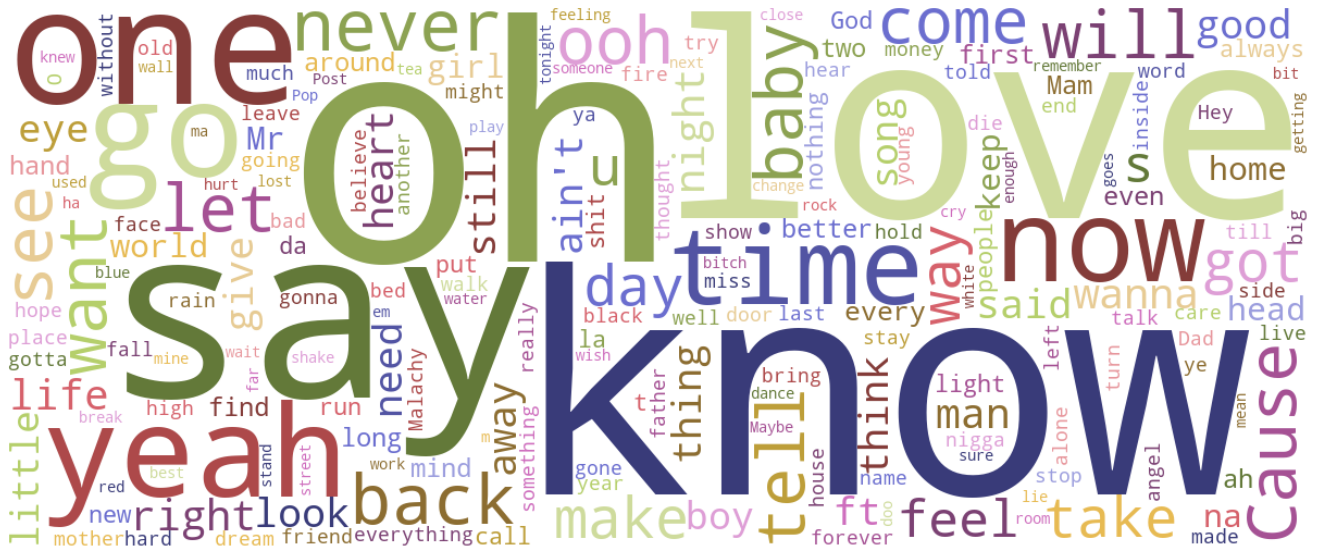

In [13]:
#Plotting the most common words with WordCloud.
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

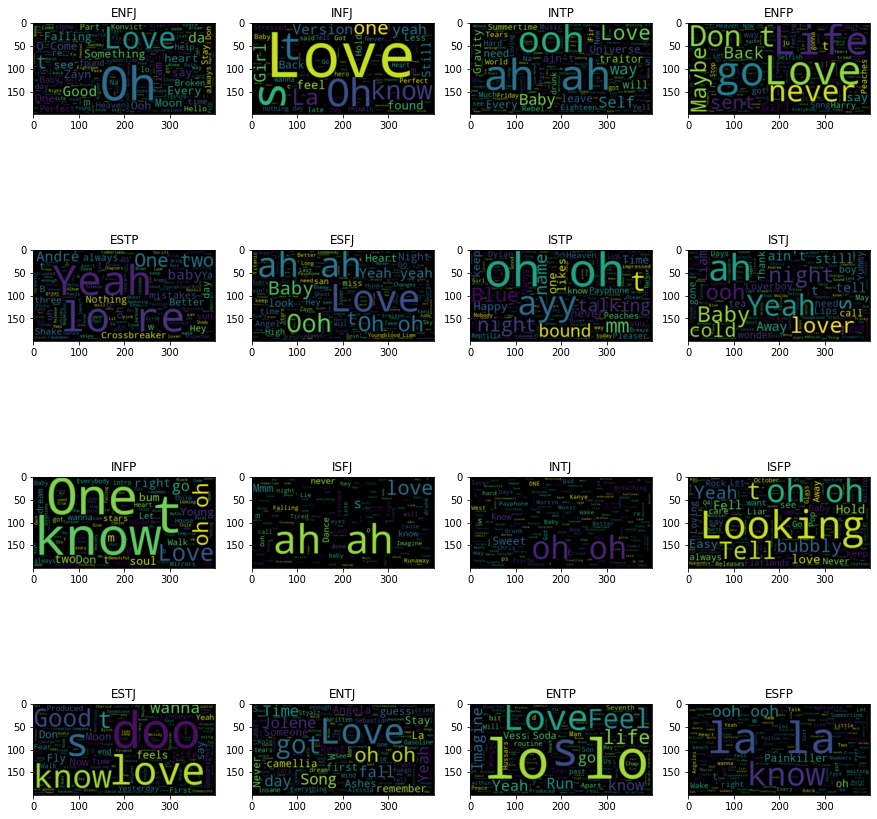

In [14]:
fig, ax = plt.subplots(len(p2_survey['MBTI'].unique()), sharex=True, figsize=(15,len(p2_survey['MBTI'].unique())))
k = 0
for i in p2_survey['MBTI'].unique():
    df_4 = p2_survey[p2_survey['MBTI'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['lyrics'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

#model

In [37]:
data = p2_survey[['MBTI','lyrics']]
data.tail()

,MBTI,lyrics
995,ISTP,"Ocean Breeze Ocean breeze. . Stop, too much, e..."
996,ISTP,"Not Your Barbie Girl []. Not your barbie girl,..."
997,ISTP,"Attention []. Woah-oh, hm-hmm. . [ 1]. You've ..."
998,ISTP,Let’s Go Here I am tied and bound. Every night...
999,ISTP,We Dem Boyz [Produced by Detail]. Yeah ayy!. Y...


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MBTI    2000 non-null   object
 1   lyrics  2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


In [39]:
# add columns for personality type indicators
def get_types(row):
    t=row['MBTI']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,MBTI,lyrics,IE,NS,TF,JP
0,ENFJ,Love Galore [Part I]. . [: Travis Scott]. I ne...,0,1,0,1
0,ENFJ,Love Galore [Part I]. . [: Travis Scott]. I ne...,0,1,0,1
0,ENFJ,Love Galore [Part I]. . [: Travis Scott]. I ne...,0,1,0,1
0,ENFJ,Love Galore [Part I]. . [: Travis Scott]. I ne...,0,1,0,1
1,ENFJ,"Over [ 1]. Every time we link up, it's only us...",0,1,0,1


In [40]:
#Counting No. of posts in one class / Total no. of posts in the other class

print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1840  /  2160
Intuition (N) / Sensing (S):		 1520  /  2480
Thinking (T) / Feeling (F):		 2560  /  1440
Judging (J) / Perceiving (P):		 1920  /  2080


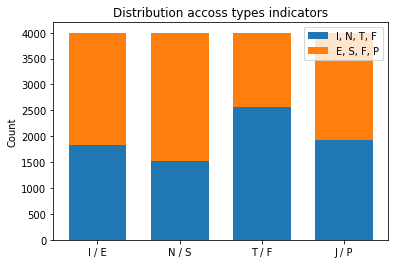

In [41]:
#Plotting the distribution of each personality type indicator
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

In [42]:
#Remove posts with less than X words
#min_words = 15
#print("Before : Number of posts", len(data)) 
data["no. of. words"] = data["lyrics"].apply(lambda x: len(re.findall(r'\w+', x)))
#data = data[data["no. of. words"] >= min_words]
data.sample(7)

,MBTI,lyrics,IE,NS,TF,JP,no. of. words
444,ENFP,Last Friday Night (T.G.I.F.) [ 1]. There's a s...,0,1,0,0,481
146,ISTJ,It’s My Life [ 1]. This ain't a song for the b...,1,0,1,1,323
830,ESFP,All We Do [ 1]. All we do is hide away. All we...,0,0,0,0,283
156,ENFJ,Fall for You [ 1]. The best thing 'bout tonigh...,0,1,0,1,311
6,INFJ,Stressed Out [ 1]. I wish I found some better ...,1,1,0,1,558
59,ENFJ,Easy On Me [ 1]. There ain't no gold in this r...,0,1,0,1,227
310,INTJ,"Sweet but Psycho []. Oh, she's sweet, but a ps...",1,1,1,1,514


In [43]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

In [44]:
data.sample(3)

,MBTI,lyrics,IE,NS,TF,JP,no. of. words
955,ISFP,Celebrities Who Have Completed the ALS Ice Buc...,1,0,0,0,1218
177,ISFP,"My Boo [: Usher, Alicia Keys & Both]. There's ...",1,0,0,0,611
572,ISFJ,"Falling []. Oh. Ooh, ooh. . []. My last made m...",1,0,0,1,352


In [45]:
# Binarizing the each personality type feature
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.MBTI])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 1 1 1]
 [0 1 1 1]
 [0 1 1 1]]


In [24]:
data.lyrics[1]

"Over [ 1]. Every time we link up, it's only us there. We're thinking, will we get there?. Is it wrong? Is it right?. You know that I miss you, but I be getting mixed signals. Why you slow down? Don't stop this green light. . []. Now you calling me special. When you know I can't have you. When I'm on to the next one. Oh, now you wan' get aggressive. Ooh, fuck do you mean?. You keep on making me leave. Nightmares turned into a dream. If you're so toxic to me, what am I fiending?. []. 'Cause I thought it was over. Got me thinking my feelings over. You keep doing it over and over. You keep calling me back. I'm just tryna gеt closure. But you pulling me closer and closеr. Phone ringing, like, over and over. 'Cause you keep calling me back. La-la-la-la-la-la-la. Why you keep calling me back? Back?. . [ 2]. Love me, then you switch up. I'd rather we never pick up. But can we slip up and mix up sometimes?. You say you don't mean it, just want it when it's convenient. Am I crazy for waiting? I

In [46]:
# Cleaning of data in the lyric
def pre_process_text(data, remove_stop_words=True):
    list_personality = []
    list_lyrics = []
    len_data = len(data)
    i=0
      
    for row in data.iterrows():
      # check code working 
      # i+=1
      # if (i % 500 == 0 or i == 1 or i == len_data):
      #     print("%s of %s rows" % (i, len_data))

        #Remove and clean comments
        lyrics = row[1].lyrics

        #Remove Non-words - keep only words
        temp = re.sub("[^a-zA-Z]", " ", lyrics)

        # Remove spaces > 1
        temp = re.sub(' +', ' ', temp).lower()

        #Remove multiple letter repeating words
        temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

        #Remove stop words
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])


      # transform mbti to binary vector
        type_labelized = translate_personality(row[1].MBTI) #or use lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        # the cleaned data temp is passed here
        list_lyrics.append(temp)

  # returns the result
    list_lyrics = np.array(list_lyrics)
    list_personality = np.array(list_personality)
    return list_lyrics, list_personality

list_lyrics, list_personality  = pre_process_text(data, remove_stop_words=True)

print("Example :")
print("\nLyrics before preprocessing:\n\n", data.lyrics[0])
print("\nLyrics after preprocessing:\n\n", list_lyrics[0])
print("\nMBTI before preprocessing:\n\n", data.MBTI[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Lyrics before preprocessing:

 0    Love Galore [Part I]. . [: Travis Scott]. I ne...
0    Love Galore [Part I]. . [: Travis Scott]. I ne...
0    Love Galore [Part I]. . [: Travis Scott]. I ne...
0    Love Galore [Part I]. . [: Travis Scott]. I ne...
Name: lyrics, dtype: object

Lyrics after preprocessing:

 love galore part travis scott need need need need need need need need need need sza love love love love long got love love love oh long got sza travis scott done nigga love nigga dust nigga fun take personal personally surprised called thing said skrrt skrrt nigga yeah skrrt nigga true skrrt actin like yeah actin like summer fling said farewell took well true promise cry spilled milk ooh give paper towel gimme another valium give another hour two hour bother know want yeah bother know got woman yeah hit know know better true know know better true know crew better call lookin ya yeah lookin ya yeah got lookin forward weekend baby baby baby true whatever want go wherever w

In [47]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 4000  and No. of Personalities = 4 


# Feature Engineering
# Tf–idf

In [48]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=770,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_lyrics)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'alone'), (1, 'always'), (2, 'another'), (3, 'around'), (4, 'away'), (5, 'baby'), (6, 'back'), (7, 'bad'), (8, 'believe'), (9, 'best')]

Using Tf-idf :
Now the dataset size is as below
(4000, 138)


# Splitting into X and Y variable
split the features as :

X: lyrics in TF-IDF representation

Y: Personality type in Binarized MBTI form

In [49]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [50]:
print("X: 1st posts in tf-idf representation\n%s" % X_tfidf[0])

X: 1st posts in tf-idf representation
[0.         0.         0.07970643 0.         0.         0.14336159
 0.         0.         0.         0.         0.10166255 0.
 0.         0.03534503 0.         0.02249161 0.         0.02746179
 0.02813915 0.0377203  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.07795824 0.         0.         0.
 0.         0.         0.07360409 0.         0.06516384 0.02305875
 0.         0.         0.         0.         0.21581396 0.
 0.         0.         0.         0.         0.         0.0404194
 0.         0.         0.         0.         0.07581701 0.03191786
 0.         0.1612733  0.03630848 0.         0.0372618  0.07784849
 0.         0.         0.         0.11924274 0.         0.
 0.22688431 0.         0.         0.57699301 0.         0.02609647
 0.         0.         0.         0.         0.         0.
 0.         0.30529003 0.04670448 0.         0.0284474  0.
 0.08737305 0.06857197

In [51]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : ENFJ
Y : Binarized MBTI 1st row: [1 0 0 0]


In [52]:
#Training & Evaluating Models
# Posts in tf-idf representation
X = X_tfidf

In [60]:
# setup parameters for xgboost
param = {}

param['n_estimators'] = 200 #100
param['max_depth'] = 2 #3
param['nthread'] = 8 #1
param['learning_rate'] = 0.2 #0.1

# Individually training each mbti personlity type
for l in range(len(personality_type)):
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    
    #EVALUATION METRICS
    import sklearn.metrics as metrics
        
    # calculate MAE
    error = mean_absolute_error(y_test, predictions)

    #MSE  
    import math
    MSE = mean_squared_error(y_test, predictions)
    RMSE = math.sqrt(MSE)
    #r squared    
    r2 = r2_score(y_test, predictions)
    
    # display
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.classification_report(y_test, predictions))
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    print("%s Mean absolute error : %.2f%%" % (personality_type[l], error))
    print("%s Root Mean Square Error: %.2f%%" % (personality_type[l], RMSE))
    print("%s r-squared : %.2f%%" % (personality_type[l], r2 ))


Recall:               precision    recall  f1-score   support

           0       0.84      0.83      0.84       745
           1       0.79      0.80      0.79       575

    accuracy                           0.82      1320
   macro avg       0.82      0.82      0.82      1320
weighted avg       0.82      0.82      0.82      1320

IE: Introversion (I) / Extroversion (E) Accuracy: 81.97%
IE: Introversion (I) / Extroversion (E) Mean absolute error : 0.18%
IE: Introversion (I) / Extroversion (E) Root Mean Square Error: 0.42%
IE: Introversion (I) / Extroversion (E) r-squared : 0.27%
Recall:               precision    recall  f1-score   support

           0       0.84      0.94      0.88       804
           1       0.88      0.72      0.79       516

    accuracy                           0.85      1320
   macro avg       0.86      0.83      0.84      1320
weighted avg       0.85      0.85      0.85      1320

NS: Intuition (N) / Sensing (S) Accuracy: 84.92%
NS: Intuition (N) / Sensing 

In [58]:
# calculate MAE
error = mean_absolute_error(y_test, predictions)
 # display
#print("%s Mean absolute error : %.2f%%" % (personality_type[l], error))
print("%s Mean absolute error : %.2f%%" % (personality_type[l], accuracy * 100.0))

#MSE  
import math
MSE = mean_squared_error(y_test, predictions)
RMSE = math.sqrt(MSE)
print("%s Root Mean Square Error: %.2f%%" % (personality_type[l], RMSE))
  
#r squared    
r2 = r2_score(y_test, predictions)
# display
print("%s r-squared : %.2f%%" % (personality_type[l], r2 ))


JP: Judging (J) / Perceiving (P) Mean absolute error : 82.50%


In [36]:
data.tail()

,MBTI,lyrics,IE,NS,TF,JP,no. of. words
995,ISTP,"Ocean Breeze Ocean breeze. . Stop, too much, e...",1,0,1,0,193
996,ISTP,"Not Your Barbie Girl []. Not your barbie girl,...",1,0,1,0,397
997,ISTP,"Attention []. Woah-oh, hm-hmm. . [ 1]. You've ...",1,0,1,0,527
998,ISTP,Let’s Go Here I am tied and bound. Every night...,1,0,1,0,201
999,ISTP,We Dem Boyz [Produced by Detail]. Yeah ayy!. Y...,1,0,1,0,410


In [37]:
len(data.MBTI.unique())

16

#prediction with unclean lyrics

In [52]:
#web scraping part -lyrics 

# Log into Genius API with the Authorization Code
client_access_token='yIyA-7gLpCLUtkU7Udq05X452sNQTNddQdcsRaPeVkz2M_xRuYXwW0pjC7sYu3Nq'
LyricsGenius = lyricsgenius.Genius(client_access_token)

# The package got some timeout issue so these two lines are needed. If you don't then there will be error when you scrape
# Source: https://github.com/johnwmillr/LyricsGenius/issues/121
LyricsGenius.timeout = 15  #timeout
LyricsGenius.sleep = 5

# Create an array to store each song's lyric
lyrics_input = []

inputt = ['shy martin - are you happy', 'summer walker - body'] # NEED TO EDIT THIS PART FOR STREAMLIT (MIN 1 SONG-MAX 5 SONGS)
# Traverse through the database, get the song's lyrics from title, and do some preprocessing
for i in inputt:
    # get title
    #song_title = ['sza - love galore', 'sza - good days']
    
    # search for song in genius.com
    searched_song = LyricsGenius.search_song(i)
    
    # if we can't find a song's lyrics then skip and append empty string
    if searched_song is None:
        lyrics_arr.append("")
        continue
        
    # get the lyric
    lyric = searched_song.lyrics
    
    # replace the lyrics newline with ". "
    lyric = lyric.replace("\n", ". ")
    
    # remove initial non-lyrics character:
    # Source: https://thispointer.com/remove-string-before-a-specific-character-in-python/
    # lyric = lyric[lyric.index('.') + 1 :]
    
    # append the processed lyric to the array
    lyrics_input.append(lyric)
    
    # remove initial non-lyrics character:
    #remove_words = '|'.join(['Chorus', 'Lyrics', 'Intro', 'Verse','Outro','Post-Chorus:','Pre-Chorus', 'Embed','Bridge'])
    #lyrics_arr = lyrics_arr.str.replace(remove_words, '')
    
lyrics_input

Searching for "shy martin - are you happy"...
Done.
Searching for "summer walker - body"...
Done.


["Are You Happy? Lyrics[Verse 1]. Another fight where no one wins again. 'Cause we don't care if we're careful anymore. So you\u2005hurt\u2005me and then\u2005I hurt you back. . [Pre-Chorus]. Do you remember\u2005how tangled we got in our feelings?. Caught up on the small things. And I know I thought that pain's a part of love. But I think I broke you, though I didn't mean to. [Chorus]. But are you happy looking back at us. When you met me?. Would you go back and tell yourself to leave it. Knowing what we know?. Or are you happy that we happened in our twenties?. So you know what you want isn't with me. Would you go back and tell yourself to leave it. Knowing how it goes?. Or are you happy that we happened? Ah. . [Post-Chorus]. Ah, ah, ah. . [Verse 2]. You taught me how to let somebody in. And how to let go of someone you love. To fall apart and then get up again. . [Pre-Chorus]. 'Cause I remember how deeply we fell in our feelings. Head first without reason. And I know I thought that 

In [57]:
#li = ' '.join([str(x) for x in lyrics_input]) - for streamlit
li = 

md = pd.DataFrame(data={'MBTI': [''], 'lyrics': [li]})
li, dummy  = pre_process_text(md, remove_stop_words=True)
my_X_cnt = cntizer.transform(li)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [58]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [59]:
print("The result is: ", translate_back(result)) 

The result is:  INFP
